In [217]:
import hoomd
import hoomd.md
import gsd.hoomd
import numpy as np
import math
import os

# Initialize HOOMD
device = hoomd.device.auto_select()  # Automatically select CPU or GPU
simulation = hoomd.Simulation(device=device)

simulation.seed = 0

# System parameters
N = 50  # Number of particles
fraction_si = 0.5  # Fraction of silicon particles
n_si = int(N * fraction_si)
n_li = N - n_si
box_length = 25  # Box size
kT = 1.5  # Target temperature in reduced units
mass_li = 6.941  # Particle mass (assumed uniform for simplicity)
mass_si = 28.0855
mass = mass_li#(mass_li + mass_si) / 2
# Create the snapshot
snapshot = hoomd.Snapshot()
snapshot.particles.N = N
snapshot.particles.types = ['Si', 'Li']
snapshot.particles.typeid[:] = [0] * n_si + [1] * n_li  # 0 for Si, 1 for Li
np.random.shuffle(snapshot.particles.typeid)  # Shuffle particle types
snapshot.particles.position[:] = np.random.uniform(
    -box_length / 2 + 1.0, box_length / 2 - 1.0, size=(N, 3)
)
snapshot.configuration.box = [box_length, box_length, box_length, 0, 0, 0]

# Initialize particles in the simulation state
simulation.create_state_from_snapshot(snapshot)

# Set initial velocities based on the desired temperature
snapshot = simulation.state.get_snapshot()
if device.communicator.rank == 0:
    np.random.seed(42)  # Seed for reproducibility
    velocities = np.random.normal(0, np.sqrt(kT / mass), size=(snapshot.particles.N, 3))
    snapshot.particles.velocity[:] = velocities
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)
simulation.state.set_snapshot(snapshot)

# LJ params from https://openkim.org/files/MO_959249795837_003/LennardJones612_UniversalShifted.params
eps_AA = 1.0496900
eps_BB = 3.1743100
sig_AA = 2.2807000
sig_BB = 1.9778000
r_cut_AA = 3#9.1228000
r_cut_BB = 3#7.9111800
# calculate A-B interactions via Lorentz-Berthelot combining rules:
eps_AB = math.sqrt(eps_AA * eps_BB)
sig_AB = (sig_AA + sig_BB) / 2
r_cut_AB = (r_cut_AA + r_cut_BB) / 2

# Define LJ potentials
cell = hoomd.md.nlist.Cell(buffer=0.4)  # Neighbor list with a buffer
lj = hoomd.md.pair.LJ(nlist = cell)
lj.params[('Li', 'Li')] = dict(epsilon=eps_AA, sigma=sig_AA)
lj.params[('Si', 'Si')] = dict(epsilon=eps_BB, sigma=sig_BB)
lj.params[('Si', 'Li')] = dict(epsilon=eps_AB, sigma=sig_AB)

lj.r_cut[('Li', 'Li')] = r_cut_AA
lj.r_cut[('Si', 'Si')] = r_cut_BB
lj.r_cut[('Si', 'Li')] = r_cut_AB

# Define the integrator and thermostat
integrator = hoomd.md.Integrator(dt=0.0001)
npt = hoomd.md.methods.ConstantPressure(
    S = 2, tauS = 1, couple = "xyz", filter=hoomd.filter.All(), thermostat = hoomd.md.methods.thermostats.Berendsen(kT=kT, tau=1)
)
integrator.methods.append(npt)
integrator.forces.append(lj)
simulation.operations.integrator = integrator

# Set up logging
thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
simulation.operations.computes.append(thermo_props)

logger = hoomd.logging.Logger()
logger.add(thermo_props, quantities=['kinetic_temperature', 'potential_energy', 'pressure', 'kinetic_energy'])

# Define GSD writer
gsd_writer = hoomd.write.GSD(
    filename="test2.gsd",
    trigger=hoomd.trigger.Periodic(1000),
    mode='wb'
)


# Add the GSD writer to the simulation operations
simulation.operations.writers.append(gsd_writer)

try:
    os.remove("test2.gsd")
except OSError:
    pass

# Run the simulation
simulation.run(1e6)
gsd_writer.flush()

In [248]:
import freud
solid = freud.order.SolidLiquid(l=6, q_threshold=0.4, solid_threshold=3)
is_solid = []
for frame in traj:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=8),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

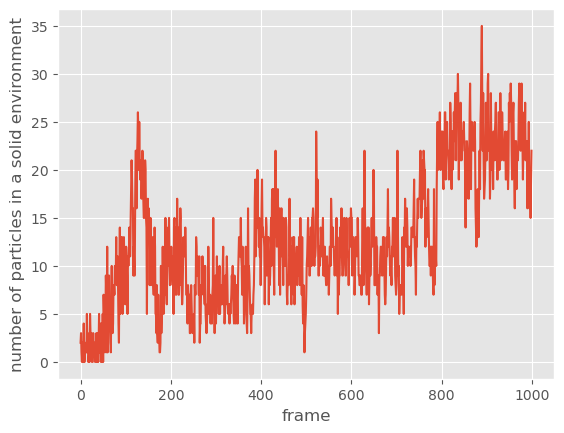

In [249]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
num_solid = numpy.array([np.sum(a) for a in is_solid])
ax.plot(num_solid[:])
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig.show()

In [34]:
with gsd.hoomd.open("test2.gsd", 'r') as traj:
    print(f"Number of frames: {len(traj)}")

Number of frames: 0


In [8]:
traj = gsd.hoomd.open('trajectory_with_efield.gsd', 'r')